In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2011,5,16)
timeStart = datetime.datetime(2011,5,16,7,0)
timeEnd = datetime.datetime(2011,5,16,10,0)
sapsTime = datetime.datetime(2011,5,16,8,36)
sapsRadList = [ "cvw" ]
sapsMlatRange = [ 56., 60. ]
sapsVelCutoff = 50.
sapsNpointsCutoff = 50 # per radar per beam

In [3]:
# read from the feather file
velsDF = feather.read_dataframe('../data/saps-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
velsDF.head()

,dateStr,timeStr,beam,range,azimCalcMag,vLos,MLAT,MLON,MLT,GLAT,GLON,radId,radCode,date,normMLT
0,20110516,700,0,2,-2.9119,1.6006,40.1949,-144.9959,16.5659,45.3684,143.7537,40,hok,2011-05-16 07:00:00,-7.4341
1,20110516,700,0,3,-1.7818,2.0959,40.6224,-144.9279,16.5705,45.8067,143.8465,40,hok,2011-05-16 07:00:00,-7.4295
2,20110516,700,0,4,-0.9696,3.3891,41.0394,-144.8684,16.5744,46.2334,143.9308,40,hok,2011-05-16 07:00:00,-7.4256
3,20110516,700,0,5,-0.3545,2.5890,41.4503,-144.8143,16.5781,46.6531,144.0106,40,hok,2011-05-16 07:00:00,-7.4219
4,20110516,700,0,6,0.1277,-0.8005,41.8574,-144.7640,16.5814,47.0682,144.0876,40,hok,2011-05-16 07:00:00,-7.4186


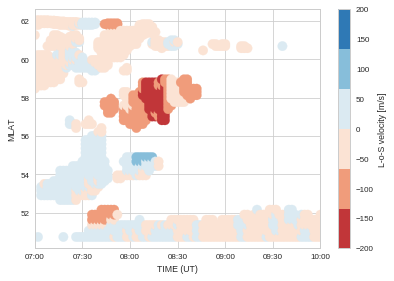

In [4]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == "cvw") &\
              (velsDF["beam"] == 7) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiPlot = ax.scatter( rtiDF["date"].values, rtiDF["MLAT"].values,\
           c=rtiDF["vLos"].values, cmap=seaMap,vmin=-200, vmax=200, s=90. )
ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-sctr-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


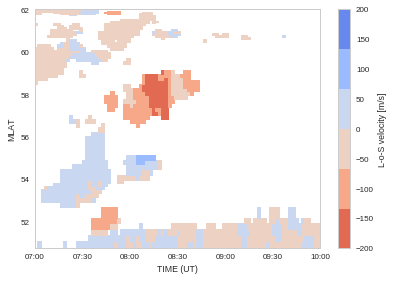

In [5]:
# sel data from a radar
rtiDF = velsDF[ (velsDF["radCode"] == "cvw") &\
              (velsDF["beam"] == 7) ]
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=-200,vmax=200)


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rtpy-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [6]:
# Filter SAPS scatter using the
# following criteria!!!
# 1) select the radars where SAPS
# is observed
sapsDF = velsDF[ velsDF["radCode"].isin(sapsRadList) ]
# 2) The flows are westward!
# So beams with negative azimuth will have
# negative LoS vels and vice-versa!
sapsDF = sapsDF[sapsDF["azimCalcMag"]/sapsDF["vLos"] > 0. ]
# 3) Set a MLAT limit
sapsDF = sapsDF[ (sapsDF["MLAT"] >= sapsMlatRange[0]) &\
               (sapsDF["MLAT"] <= sapsMlatRange[1]) ]
# 4) Set a velocity cutoff
sapsDF = sapsDF[ numpy.abs(sapsDF["vLos"]) >= sapsVelCutoff ]
# 5) Finally group by radar and beam number to
# discard velocities whose values are
cntPntsSAPSGrp = sapsDF.groupby( ["radCode", "beam"] ).size().reset_index()
# cntPntsSAPSGrp.columns = ["radCode", "beam", "nPoints"]
# sapsDF = pandas.merge( sapsDF, cntPntsSAPSGrp, on=["radCode", "beam"] )
# sapsDF = sapsDF[ sapsDF["nPoints"] >= sapsNpointsCutoff ]

206


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


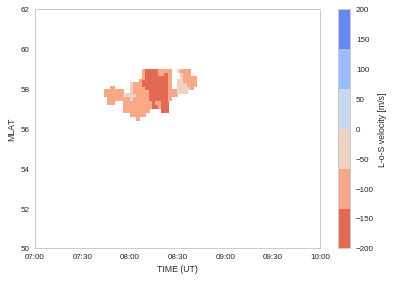

In [7]:
# sel data from a radar and beam
rtiDF = sapsDF[ (sapsDF["radCode"] == "cvw") &\
               (sapsDF["beam"] == 7) ]
print len(rtiDF.index)
# Make an RTIish Plot
# Seaborn styling
sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
rtiDF["dtNum"] = [ date2num(x) for x in rtiDF["date"] ]
plotDF = rtiDF[ ["MLAT", "dtNum",\
                        "vLos"] ].pivot( "MLAT", "dtNum" )
mlatVals = plotDF.index.values
timeVals = plotDF.columns.levels[1].values

timeCntr, mlatCntr  = numpy.meshgrid( timeVals, mlatVals )
# Mask the nan values! pcolormesh can't handle them well!
vLosVals = numpy.ma.masked_where(numpy.isnan(plotDF["vLos"].values),plotDF["vLos"].values)
rtiPlot = ax.pcolormesh(timeCntr, mlatCntr, vLosVals, cmap=seaMap, vmin=-200,vmax=200)


ax.set_xlim( [ timeStart, timeEnd ] )
ax.set_ylim( [50,62] )
ax.set_xlabel("TIME (UT)")
ax.set_ylabel("MLAT")
ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


cbar = plt.colorbar(rtiPlot, orientation='vertical')
cbar.set_label("L-o-S velocity [m/s]")
fig.savefig( "../plots/rt-saps-" + eventDate.strftime("%Y%m%d") + ".pdf",bbox_inches='tight' )

In [8]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))
# Get l-shell fitted velocities from
# the SAPS vLos at different time intervals
lshellDF = sapsDF[ sapsDF["date"] == sapsTime ]
# groupby rounded azimuth to 
# get median vLos to Lshell fit
lshellDF["azimRnd"] = lshellDF["azimCalcMag"].round()#apply(lambda x: custom_round(x, base=5))
selCols = [ "vLos", "MLAT", "normMLT", "azimRnd" ]
azimDF = lshellDF[selCols].groupby( ["azimRnd"] ).median().reset_index()
azimDF.columns = [ "azimRnd", "vLos_median", "MLAT_mean", "normMLT_mean" ]
azimStdDF = lshellDF[selCols].groupby( ["azimRnd"] ).std().reset_index()
azimStdDF.columns = [ "azimRnd", "vLos_std", "MLAT_std", "normMLT_std" ]
azimDF = pandas.merge( azimDF, azimStdDF, on="azimRnd" )
# discard azims with less count
azimCntDF = lshellDF.groupby("azimRnd").size().reset_index()
azimCntDF.columns = [ "azimRnd", "nPnts" ]
azimDF = pandas.merge( azimDF, azimCntDF, on="azimRnd" )
# discard azimuths where number of points is less than
# 50% of the maximum (observed across all azimuths)
azimDF["percCnt"] = azimDF["nPnts"]*100./azimDF["nPnts"].max()
azimDF = azimDF[ azimDF["percCnt"] >= 33. ]
print azimDF

    azimRnd  vLos_median  MLAT_mean  normMLT_mean   vLos_std  MLAT_std  \
0     -70.0    -92.52745   57.05160      -1.60400   5.563021  0.077075   
2     -68.0   -101.88670   56.70770      -1.47600   0.377878  0.084994   
3     -67.0   -122.71540   56.52360      -1.41270  22.647356  0.990653   
4     -66.0    -83.41430   57.97485      -1.56340   0.000000  0.094682   
5     -65.0    -96.50180   57.69970      -1.47810   0.057558  0.099843   
7     -63.0   -108.98700   57.25980      -1.35215  25.674340  0.107480   
8     -62.0    -75.33800   58.88140      -1.51490   0.228820  0.112430   
9     -61.0    -78.17205   58.55625      -1.43030   1.297046  0.117450   
11    -59.0    -65.51155   58.04250      -1.30590   6.589882  0.124734   
13      0.0     93.69420   57.52610      -0.05110   2.557903  0.420701   
14      3.0     87.91435   59.46410       0.00835  13.935448  0.295005   
15      4.0     95.71630   57.99550       0.00440  14.728716  0.668445   
16      7.0     94.42630   58.64705   

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


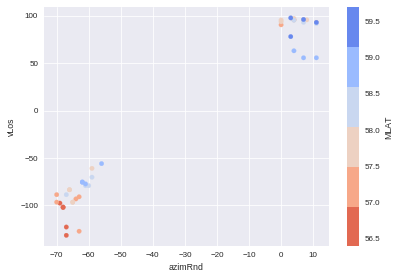

In [13]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("coolwarm_r"))
lshellDF.plot( kind='scatter',
              x='azimRnd',
              y='vLos',
              c='MLAT',
              s=20., cmap=seaMap, ax=ax)
fig1.savefig("../plots/lshell-test.pdf",bbox_inches='tight')

In [10]:
# Some fitting functions
# Fit a sine curve for a given cell
def vel_sine_func(theta, Vmax, delTheta):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )

def model_func(theta, Vmax, delTheta):
    vLos = Vmax * numpy.sin( numpy.deg2rad(theta) +\
                            numpy.deg2rad(delTheta) )
    return vLos

initGuess = ( 1000., 10. )

vMax---> 161.900044456 +/- 6.38876282339
delTheta---> 30.1109402686 +/- 1.56921610426


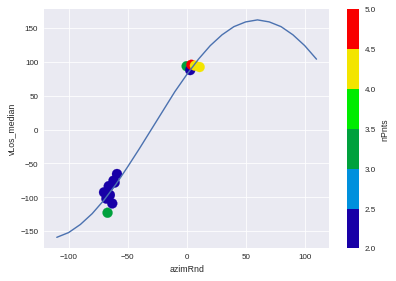

In [11]:
# Fit the data
popt, pcov = scipy.optimize.curve_fit(vel_sine_func, \
                    azimDF["azimRnd"].T,\
                    azimDF['vLos_median'].T,
                   p0=initGuess)
# fitted params
print "vMax--->", popt[0],"+/-", pcov[0,0]**0.5
print "delTheta--->", popt[1],"+/-", pcov[1,1]**0.5
# curve for plotting
thetaArr = range(-110, 120, 10)
vLosArr = [ round( model_func(t, popt[0],popt[1]) ) for t in thetaArr ]
# Plots
fig1 = plt.figure()
ax = fig1.add_subplot(111)
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("spectral"))
azimDF.plot( kind='scatter',
              x='azimRnd',
              y='vLos_median',
              c='nPnts',
              s=100., cmap=seaMap, ax=ax)
ax.plot( thetaArr, vLosArr )

In [17]:
test = sapsDF[ sapsDF["date"] == sapsTime ]
print test[ ["MLAT", "normMLT"] ]

           MLAT  normMLT
187501  56.3960  -1.3707
187502  56.5236  -1.4127
187503  56.6476  -1.4548
187504  56.7678  -1.4972
187505  56.8843  -1.5397
187506  56.9971  -1.5825
187507  57.1061  -1.6255
187517  57.1838  -1.3314
187518  57.3358  -1.3729
187519  57.4842  -1.4148
187520  57.6291  -1.4569
187521  57.7703  -1.4993
187522  57.9079  -1.5419
187523  58.0418  -1.5849
187524  58.1721  -1.6281
187529  57.9543  -1.2854
187530  58.1307  -1.3264
187531  58.3037  -1.3677
187532  58.4732  -1.4093
187533  58.6393  -1.4513
187534  58.8019  -1.4936
187535  58.9609  -1.5362
187544  59.1016  -1.3132
187711  57.1042  -0.0481
187712  57.5261  -0.0511
187713  57.9456  -0.0539
187731  57.1458   0.0036
187732  57.5719   0.0038
187733  57.9955   0.0044
187734  58.4171   0.0052
187735  58.8370   0.0062
187736  59.2555   0.0076
187737  59.6727   0.0091
187752  57.5860   0.0588
187753  58.0121   0.0627
187754  58.4360   0.0670
187755  58.8581   0.0716
187757  59.6977   0.0818
187772  57.9951   0.1209


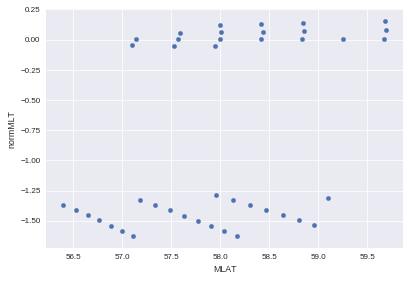

In [19]:
test.plot(x="MLAT",y="normMLT",kind="scatter")